In [1]:
# Source: https://nilearn.github.io/stable/auto_examples/02_decoding/plot_oasis_vbm.html#sphx-glr-auto-examples-02-decoding-plot-oasis-vbm-py

import numpy as np

from nilearn import datasets
from nilearn.image import get_data
from nilearn.maskers import NiftiMasker

n_subjects = 100  # more subjects requires more memory


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\ruthb\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\ruthb\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\ruthb\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ruthb\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\ruthb\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\ruthb\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\ruthb\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\ruthb\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ruthb\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\ruthb\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

In [2]:
oasis_dataset = datasets.fetch_oasis_vbm(
    n_subjects=n_subjects, legacy_format=False
)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars["age"].values

# Split data into training set and test set
from sklearn.model_selection import train_test_split

gm_imgs_train, gm_imgs_test, age_train, age_test = train_test_split(
    gray_matter_map_filenames, age, train_size=0.6, random_state=0
)

# print basic information on the dataset
print(
    "First gray-matter anatomy image (3D) is located at: "
    f"{oasis_dataset.gray_matter_maps[0]}"
)
print(
    "First white-matter anatomy image (3D) is located at: "
    f"{oasis_dataset.white_matter_maps[0]}"
)


Dataset created in C:\Users\ruthb/nilearn_data\oasis1



Downloaded 904765440 of 905208634 bytes (100.0%,    0.0s remaining) ...done. (31 seconds, 0 min)
Extracting data from C:\Users\ruthb/nilearn_data\oasis1\561b22d40f63ba06f5dd26ca6a4a49fe\archive_dartel.tgz..... done.


First gray-matter anatomy image (3D) is located at: C:\Users\ruthb/nilearn_data\oasis1\OAS1_0001_MR1\mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
First white-matter anatomy image (3D) is located at: C:\Users\ruthb/nilearn_data\oasis1\OAS1_0001_MR1\mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


In [3]:
nifti_masker = NiftiMasker(
    standardize=False, smoothing_fwhm=2, memory="nilearn_cache"
)  # cache options
gm_maps_masked = nifti_masker.fit_transform(gm_imgs_train)

# The features with too low between-subject variance are removed using
# :class:`sklearn.feature_selection.VarianceThreshold`.
from sklearn.feature_selection import VarianceThreshold

variance_threshold = VarianceThreshold(threshold=0.01)
variance_threshold.fit_transform(gm_maps_masked)

# Then we convert the data back to the mask image in order to use it for
# decoding process
mask = nifti_masker.inverse_transform(variance_threshold.get_support())

In [4]:
from nilearn.decoding import DecoderRegressor

decoder = DecoderRegressor(
    estimator="svr",
    mask=mask,
    scoring="neg_mean_absolute_error",
    screening_percentile=1,
    n_jobs=2,
    standardize="zscore_sample",
)
# Fit and predict with the decoder
decoder.fit(gm_imgs_train, age_train)

# Sort test data for better visualization (trend, etc.)
perm = np.argsort(age_test)[::-1]
age_test = age_test[perm]
gm_imgs_test = np.array(gm_imgs_test)[perm]
age_pred = decoder.predict(gm_imgs_test)

prediction_score = -np.mean(decoder.cv_scores_["beta"])

print("=== DECODER ===")
print(f"explained variance for the cross-validation: {prediction_score:f}")
print()

=== DECODER ===
explained variance for the cross-validation: 10.670599



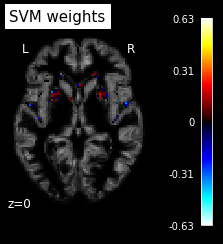

In [5]:
weight_img = decoder.coef_img_["beta"]

# Create the figure
from nilearn.plotting import plot_stat_map, show

bg_filename = gray_matter_map_filenames[0]
z_slice = 0
display = plot_stat_map(
    weight_img, bg_img=bg_filename, display_mode="z", cut_coords=[z_slice]
)
display.title("SVM weights")
show()

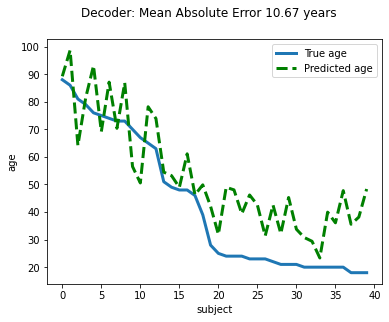

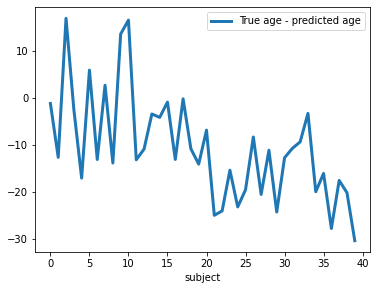

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4.5))
plt.suptitle(f"Decoder: Mean Absolute Error {prediction_score:.2f} years")
linewidth = 3
plt.plot(age_test, label="True age", linewidth=linewidth)
plt.plot(age_pred, "--", c="g", label="Predicted age", linewidth=linewidth)
plt.ylabel("age")
plt.xlabel("subject")
plt.legend(loc="best")
plt.figure(figsize=(6, 4.5))
plt.plot(
    age_test - age_pred, label="True age - predicted age", linewidth=linewidth
)
plt.xlabel("subject")
plt.legend(loc="best")

In [ ]:
print("Massively univariate model")

gm_maps_masked = NiftiMasker().fit_transform(gray_matter_map_filenames)
data = variance_threshold.fit_transform(gm_maps_masked)

# Statistical inference
from nilearn.mass_univariate import permuted_ols

# This can be changed to use more CPUs.
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age,
    data,  # + intercept as a covariate by default
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    verbose=1,  # display progress bar
    n_jobs=2,
)
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals)
)

# Show results
threshold = -np.log10(0.1)  # 10% corrected

fig = plt.figure(figsize=(5.5, 7.5), facecolor="k")

display = plot_stat_map(
    signed_neg_log_pvals_unmasked,
    bg_img=bg_filename,
    threshold=threshold,
    cmap=plt.cm.RdBu_r,
    display_mode="z",
    cut_coords=[z_slice],
    figure=fig,
)
title = (
    "Negative $\\log_{10}$ p-values" "\n(Non-parametric + max-type correction)"
)
display.title(title)

n_detections = (get_data(signed_neg_log_pvals_unmasked) > threshold).sum()
print(f"\n{int(n_detections)} detections")

show()

Massively univariate model


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
